In [1]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 1.2 MB/s eta 0:00:00


In [2]:
# necessary imports
import os
import shutil
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import networkx as nx
import matplotlib.patches as patches
from PIL import Image
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc
import itertools

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

import keras_tuner as kt

from google.colab import files
from google.colab import drive

In [3]:
# mount g drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
drive_path = '/content/drive/MyDrive/AAI-590 Capstone/'

# Indexing Image Directories

In [5]:
df = pd.read_csv(drive_path + 'Data_Entry_2017.csv')

In [6]:
image_paths = {}

for subdir, _, files in os.walk(drive_path):
    for file in files:
        if file.endswith('.png'):
            # Ensure the dictionary key is just the filename
            image_paths[file] = os.path.join(subdir, file)

print(f"Found {len(image_paths)} images.")

Found 112132 images.


In [7]:
df['Image Path'] = df['Image Index'].apply(lambda x: image_paths.get(x))

In [8]:
df.to_csv(drive_path + 'Data_with_image_paths.csv')

# EDA

In [9]:
df = pd.read_csv(drive_path + 'Data_with_image_paths.csv')
df.head()

,Unnamed: 0,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,Image Path
0,0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN,/content/drive/MyDrive/AAI-590 Capstone/images...
1,1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN,/content/drive/MyDrive/AAI-590 Capstone/images...
2,2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN,/content/drive/MyDrive/AAI-590 Capstone/images...
3,3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN,/content/drive/MyDrive/AAI-590 Capstone/images...
4,4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN,/content/drive/MyDrive/AAI-590 Capstone/images...


## Dataset Overview and Descriptive statistics

In [10]:
print("Number of Rows:", len(df))
print("Number of Unique Images:", df["Image Index"].nunique())
print("Number of Unique Patients:", df["Patient ID"].nunique())

# Utilizing `df.describe()` to generate descriptive statistics for numerical columns.
df.describe()

Number of Rows: 112120
Number of Unique Images: 112120
Number of Unique Patients: 30805


,Unnamed: 0,Follow-up #,Patient ID,Patient Age,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
count,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,0.0
mean,56059.500000,8.573751,14346.381743,46.901463,2646.078844,2486.438842,0.155649,0.155649,NaN
std,32366.400428,15.406320,8403.876972,16.839923,341.246429,401.268227,0.016174,0.016174,NaN
min,0.000000,0.000000,1.000000,1.000000,1143.000000,966.000000,0.115000,0.115000,NaN
25%,28029.750000,0.000000,7310.750000,35.000000,2500.000000,2048.000000,0.143000,0.143000,NaN
50%,56059.500000,3.000000,13993.000000,49.000000,2518.000000,2544.000000,0.143000,0.143000,NaN
75%,84089.250000,10.000000,20673.000000,59.000000,2992.000000,2991.000000,0.168000,0.168000,NaN
max,112119.000000,183.000000,30805.000000,414.000000,3827.000000,4715.000000,0.198800,0.198800,NaN


## Filtering and missing data

In [11]:
# Addressing potential age entry errors by removing records with ages above 120 years.
df = df[df['Patient Age'] <= 120]
df.reset_index(drop=True, inplace=True)

In [12]:
# check for NA values
df.isna().sum()

Unnamed: 0                          0
Image Index                         0
Finding Labels                      0
Follow-up #                         0
Patient ID                          0
Patient Age                         0
Patient Gender                      0
View Position                       0
OriginalImage[Width                 0
Height]                             0
OriginalImagePixelSpacing[x         0
y]                                  0
Unnamed: 11                    112104
Image Path                          0
dtype: int64

In [13]:
df.drop(columns='Unnamed: 11', inplace=True)

<ipython-input-13-81dd2d83a1dc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns='Unnamed: 11', inplace=True)


In [14]:
### Random Sample: 15% of dataset ###


# Top Labels
top_labels = ['No Finding', 'Infiltration', 'Effusion', 'Atelectasis']
filtered_df = df[df['Finding Labels'].apply(lambda x: all(label in top_labels for label in x.split('|')))]
df = filtered_df.sample(frac=0.15, random_state=1997).reset_index(drop=True)
df.to_csv(drive_path + 'Sampled_Data_with_image_paths.csv', index=False)
print("15% random sample dataset created.")

15% random sample dataset created.


In [15]:
### Larger Sample: Maximimum for Atelectasis, Effusion, and Infiltration ###



#top_labels = ['No Finding', 'Infiltration', 'Effusion', 'Atelectasis']
#filtered_df = df[df['Finding Labels'].apply(lambda x: all(label in top_labels for label in x.split('|')))]

# Function to sample the data
#def sample_data(df, label, num_samples):
#    label_df = df[df['Finding Labels'].str.contains(label)]
#    return label_df.sample(n=num_samples, random_state=1997, replace=len(label_df) < num_samples)

# Sample 40,000 'No Finding', and maximum available for 'Infiltration', 'Effusion', and 'Atelectasis'
#no_finding_sampled = sample_data(filtered_df, 'No Finding', 40000)
#infiltration_sampled = sample_data(filtered_df, 'Infiltration', filtered_df[filtered_df['Finding Labels'].str.contains('Infiltration')].shape[0])
#effusion_sampled = sample_data(filtered_df, 'Effusion', filtered_df[filtered_df['Finding Labels'].str.contains('Effusion')].shape[0])
#atelectasis_sampled = sample_data(filtered_df, 'Atelectasis', filtered_df[filtered_df['Finding Labels'].str.contains('Atelectasis')].shape[0])


#balanced_df = pd.concat([no_finding_sampled, infiltration_sampled, effusion_sampled, atelectasis_sampled])
#df = balanced_df.sample(frac=1, random_state=1997).reset_index(drop=True)
#df.to_csv(drive_path + 'Balanced_Data_with_image_paths.csv', index=False)
#print("Dataset created.")

## Variable Exploration

### Image index
The 'Image Index' holds valuable information encoded in the file names (e.g., 00000001_000.png). The number preceding the underscore corresponds to the 'Patient ID', while the number after represents the image number for that patient.

In [16]:
print(df["Image Index"][0:5])

0    00006413_000.png
1    00018490_000.png
2    00005699_000.png
3    00022046_000.png
4    00007930_000.png
Name: Image Index, dtype: object


### Target

Key Characteristics:

Multi-label Classification: Images can have "No Finding" or one or more of 14 disease classes (Atelectasis, Consolidation, Infiltration, etc.).

Label Combinations: There are numerous unique combinations of labels, requiring careful handling during model training.

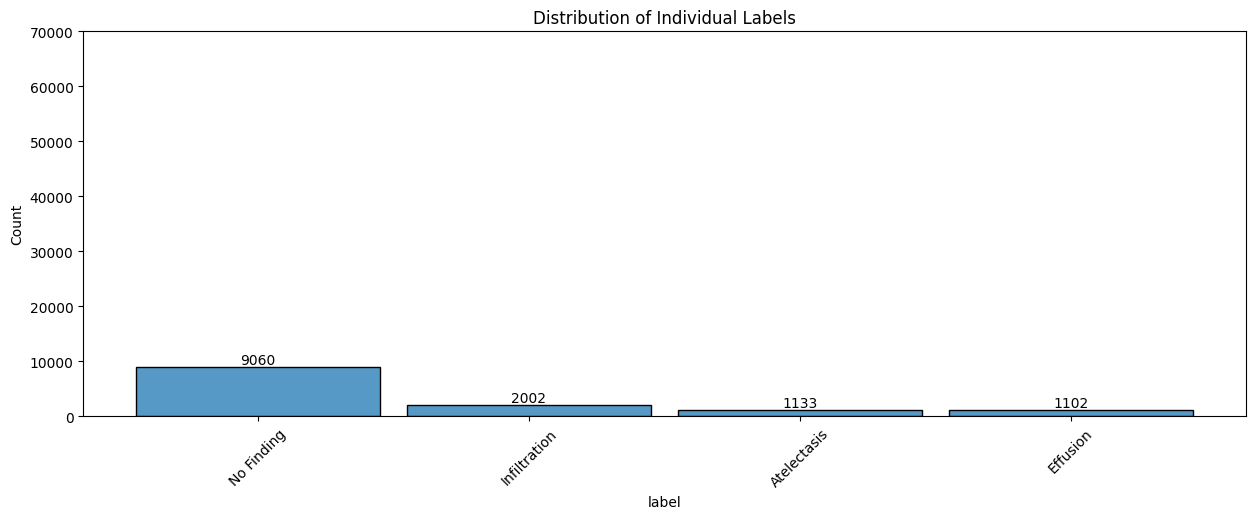

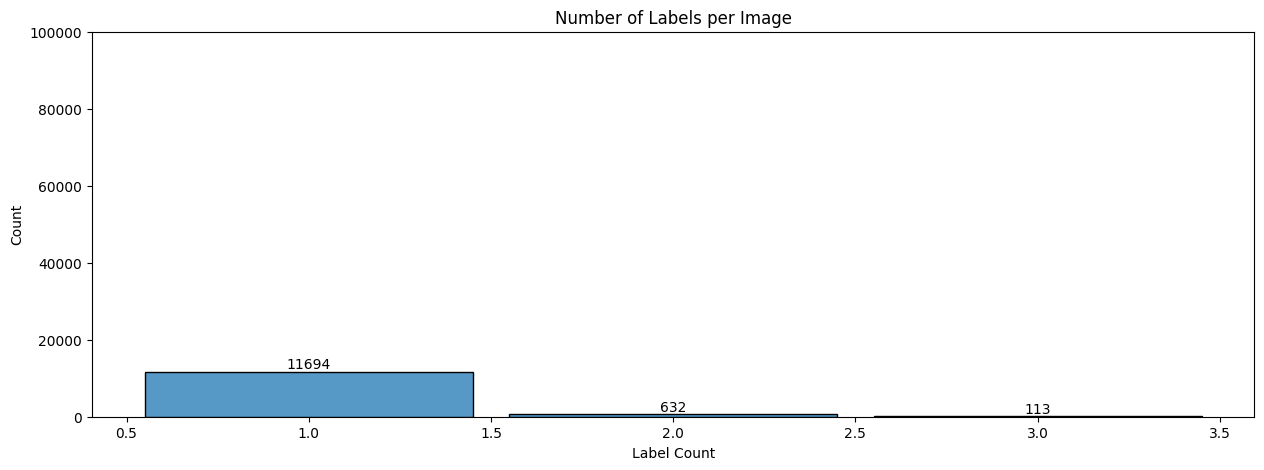

In [17]:
# Splitting labels and counting occurrences
label_counts = df.assign(
    var1=df['Finding Labels'].str.split('|')).explode('var1')["var1"]
label_counts = label_counts.reset_index(drop=True).to_frame()
label_counts.columns = ["label"]

fig, ax = plt.subplots(figsize=(15, 5))
ax.tick_params(axis='x', rotation=45)
sns.histplot(
    label_counts, x="label", discrete=True, ax=ax, shrink=.9).set_title(
        "Distribution of Individual Labels")
ax.bar_label(ax.containers[0])
plt.ylim(0, 70000)
plt.show()

# Analyzing the number of labels per image
labels_per_image = df["Finding Labels"].str.count(r'\|') + 1
labels_per_image = labels_per_image.reset_index(drop=True).to_frame()
labels_per_image.columns = ["Label Count"]

fig, ax = plt.subplots(figsize=(15, 5))
sns.histplot(
    labels_per_image,
    x="Label Count",
    discrete=True,
    ax=ax,
    shrink=.9).set_title("Number of Labels per Image")
ax.bar_label(ax.containers[0])
plt.ylim(0, 100000)
plt.show()

### Other Features

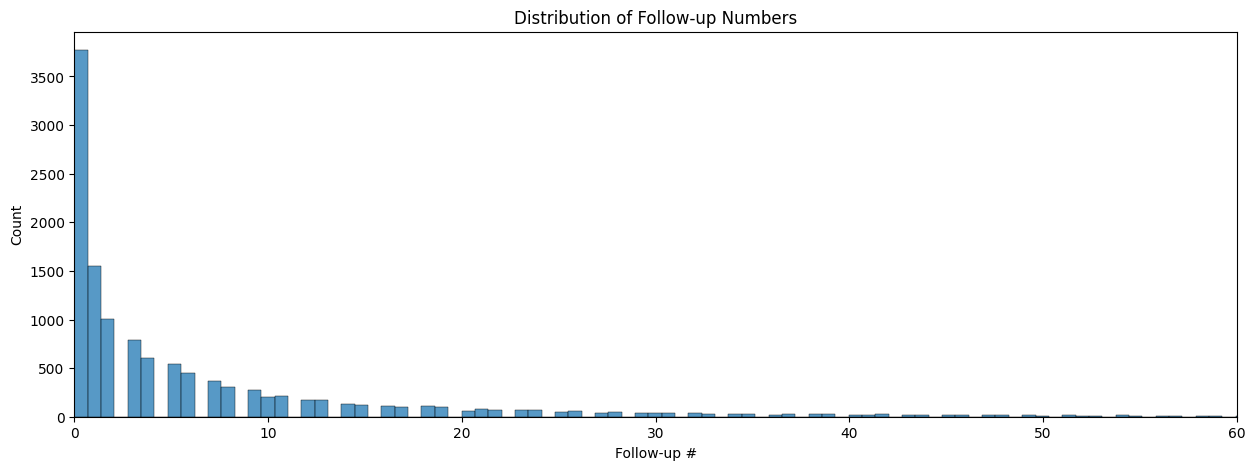

In [18]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.histplot(data=df, x="Follow-up #", ax=ax).set_title(
    'Distribution of Follow-up Numbers')
plt.xlim(0, 60)
plt.show()

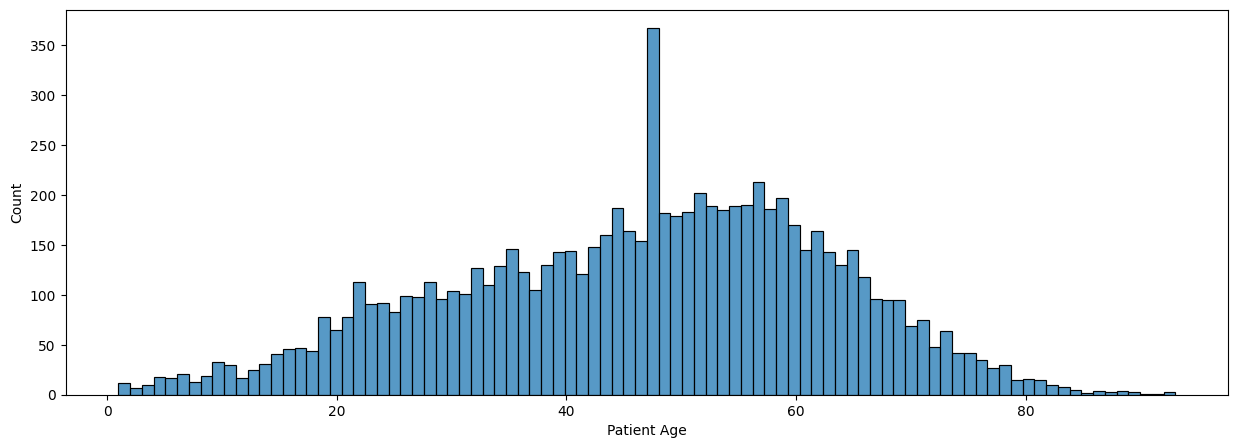

In [19]:
test = df.groupby("Patient ID").agg('first')

fig, ax = plt.subplots(figsize=(15, 5))
sns.histplot(test, x="Patient Age", ax=ax, bins=90)
plt.show()

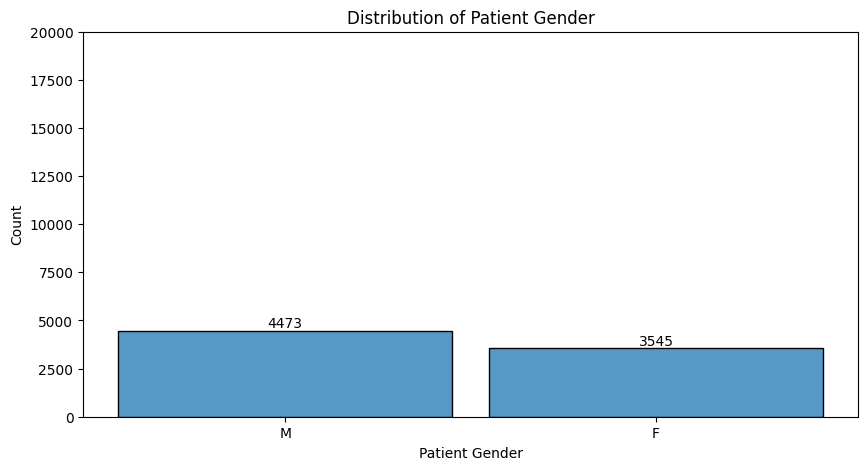

In [20]:
test = df.groupby("Patient ID").agg('first')

fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(
    test,
    x="Patient Gender",
    discrete=True,
    ax=ax,
    shrink=.9).set_title("Distribution of Patient Gender")
ax.bar_label(ax.containers[0])
plt.ylim(0, 20000)
plt.show()

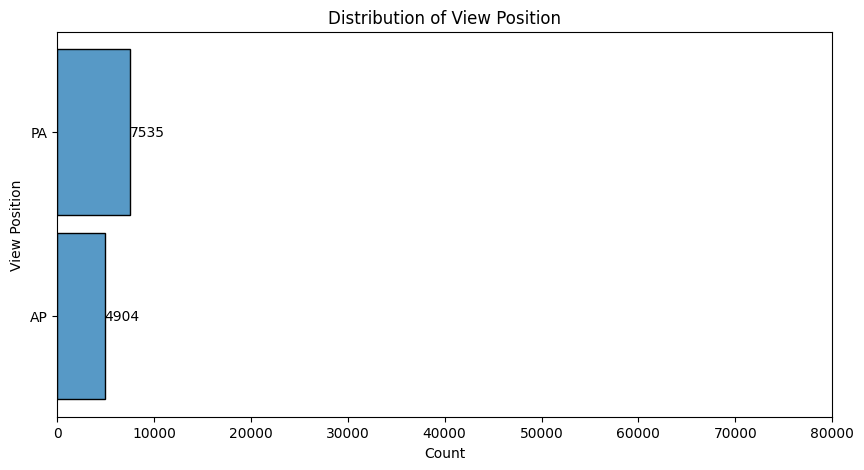

In [21]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(
    df, y='View Position', discrete=True, ax=ax, shrink=.9).set_title(
        "Distribution of View Position")
ax.bar_label(ax.containers[0])
plt.xlim(0, 80000)
plt.show()

## Feature relationships

In [22]:
cols_of_interest = [
    "Image Index", "Finding Labels", "Follow-up #", "Patient ID",
    "Patient Age", "Patient Gender", "View Position", 'Image Path'
]

df = df[cols_of_interest]

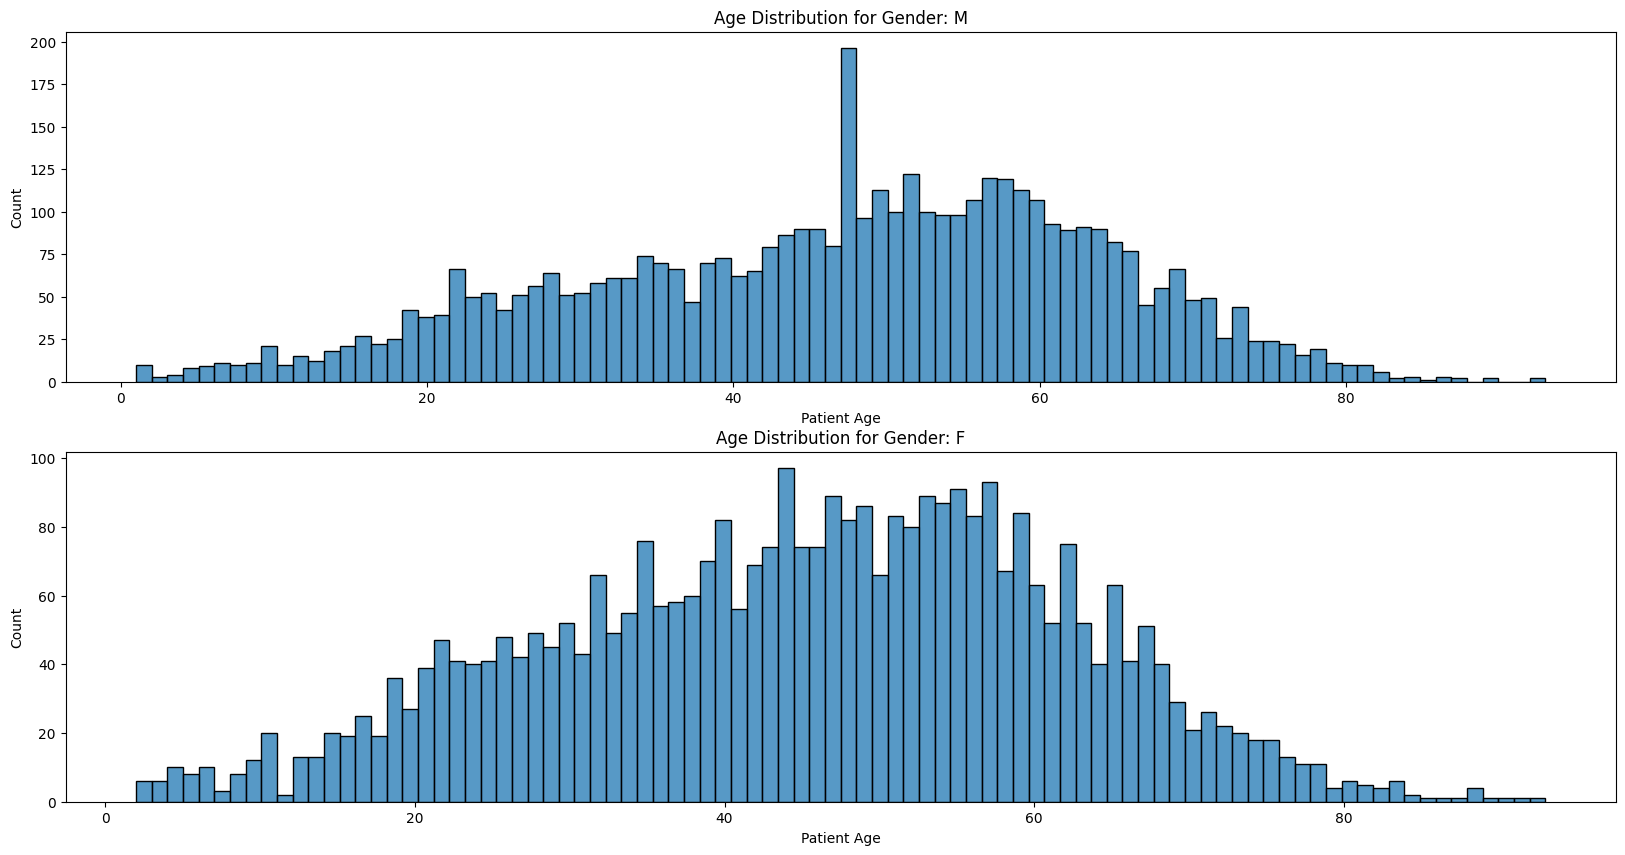

In [23]:
test = df.groupby("Patient ID").agg('first')
fig, axes = plt.subplots(2, 1, figsize=(20, 10))

for i, val in enumerate(["M", "F"]):
    test1 = test[test['Patient Gender'] == val].reset_index()
    sns.histplot(test1, x="Patient Age", ax=axes[i], bins=90)
    axes[i].set_title(f"Age Distribution for Gender: {val}")

plt.show()

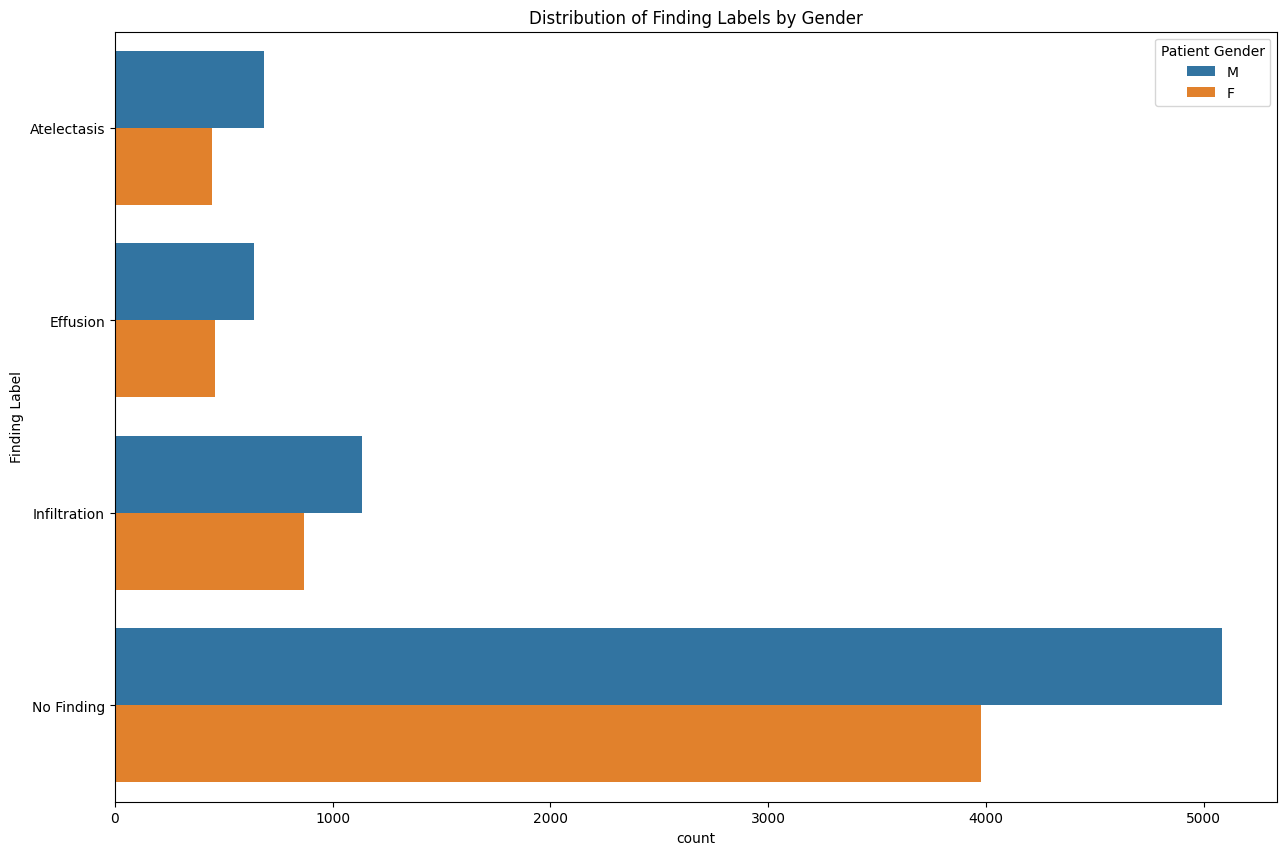

In [24]:
test = df.assign(var1=df['Finding Labels'].str.split('|')).explode('var1')
plot_df = pd.DataFrame()

for val in ["M", "F"]:
    test1 = test[test["Patient Gender"] == val].reset_index(drop=True)
    test1 = test1.groupby("var1").size().sort_index().reset_index(
        name="count")
    test1["Patient Gender"] = val

    plot_df = pd.concat([plot_df, test1]).reset_index(drop=True)

plt.figure(figsize=(15, 10))
plt.title("Distribution of Finding Labels by Gender")
ax = sns.barplot(
    y="var1", hue="Patient Gender", x="count", data=plot_df, orient='h')
plt.ylabel("Finding Label")
plt.show()

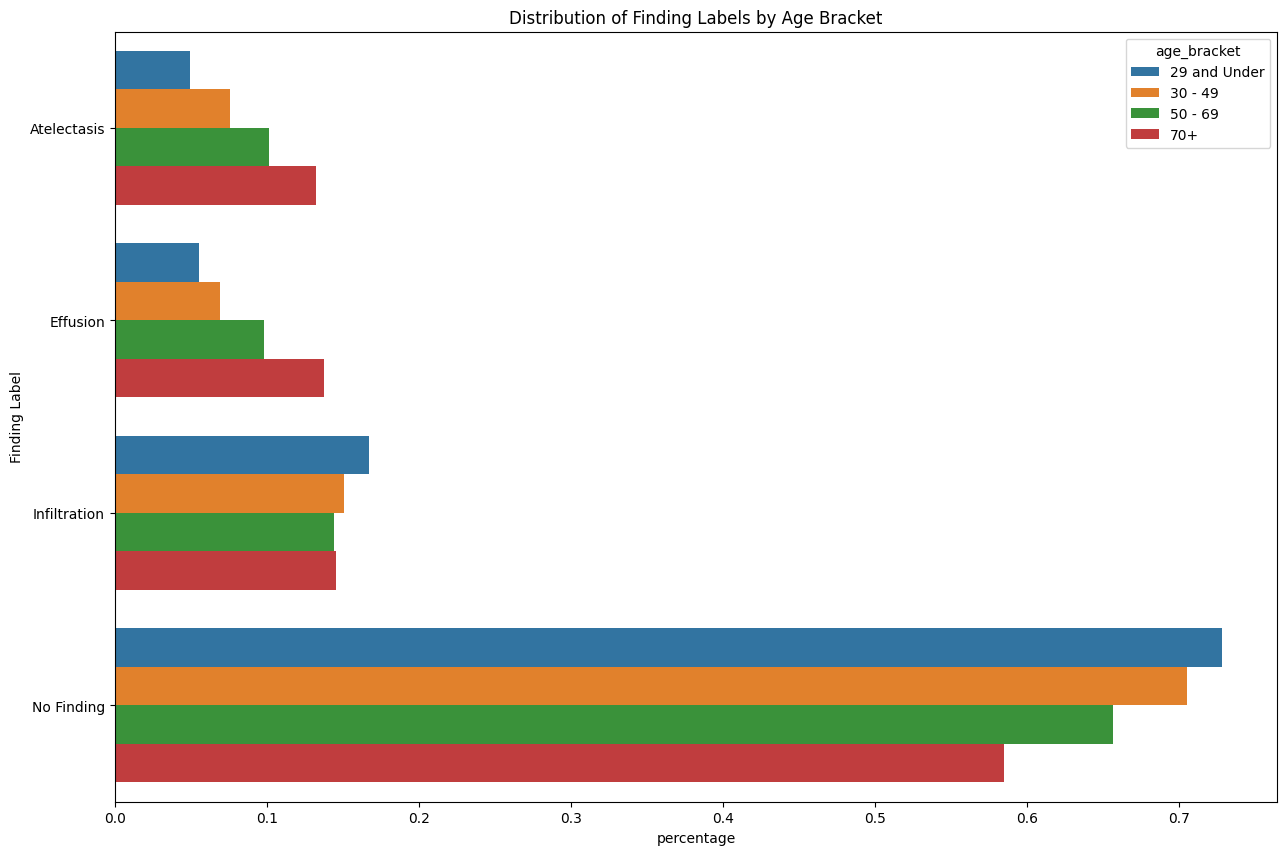

In [25]:
test = df.assign(var1=df['Finding Labels'].str.split('|')).explode('var1')

conditions = [
    (test['Patient Age'] <= 29),
    (test['Patient Age'] >= 30) & (test['Patient Age'] <= 49),
    (test['Patient Age'] >= 50) & (test['Patient Age'] <= 69),
    (test['Patient Age'] >= 70)
]

choices = ['29 and Under', '30 - 49', '50 - 69', '70+']
test['age_bracket'] = np.select(conditions, choices, default=np.nan)
test1 = test.groupby(
    ["age_bracket", "var1"]).size().sort_index().reset_index(name="count")
test2 = test1.groupby("age_bracket").sum("count").reset_index()

test1 = test1.merge(test2, on='age_bracket', suffixes=('', '_total'))
test1["percentage"] = test1["count"] / test1["count_total"]

plt.figure(figsize=(15, 10))
plt.title("Distribution of Finding Labels by Age Bracket")
ax = sns.barplot(
    y="var1",
    hue="age_bracket",
    x="percentage",
    data=test1,
    orient='h')
plt.ylabel("Finding Label")
plt.show()

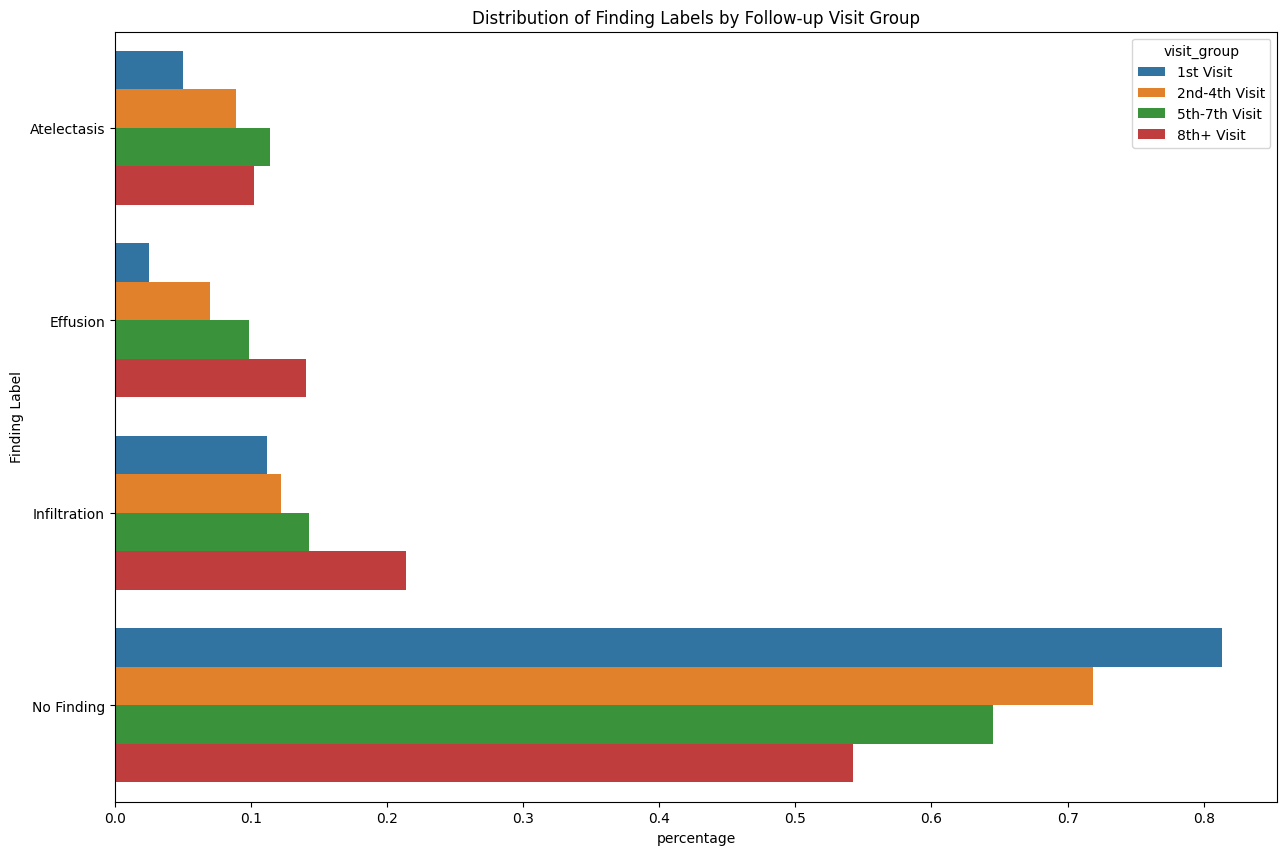

In [26]:
test = df.assign(var1=df['Finding Labels'].str.split('|')).explode('var1')

conditions = [
    (test['Follow-up #'] == 0),  # First visit
    (test['Follow-up #'] >= 1) & (test['Follow-up #'] <= 3),
    (test['Follow-up #'] >= 4) & (test['Follow-up #'] <= 6),
    (test['Follow-up #'] >= 7)
]

choices = ['1st Visit', '2nd-4th Visit', '5th-7th Visit', '8th+ Visit']
test['visit_group'] = np.select(conditions, choices, default=np.nan)
test1 = test.groupby(
    ["visit_group", "var1"]).size().sort_index().reset_index(name="count")
test2 = test1.groupby("visit_group").sum("count").reset_index()

test1 = test1.merge(test2, on='visit_group', suffixes=('', '_total'))
test1["percentage"] = test1["count"] / test1["count_total"]

plt.figure(figsize=(15, 10))
plt.title("Distribution of Finding Labels by Follow-up Visit Group")
ax = sns.barplot(
    y="var1", hue="visit_group", x="percentage", data=test1, orient='h')
plt.ylabel("Finding Label")
plt.show()

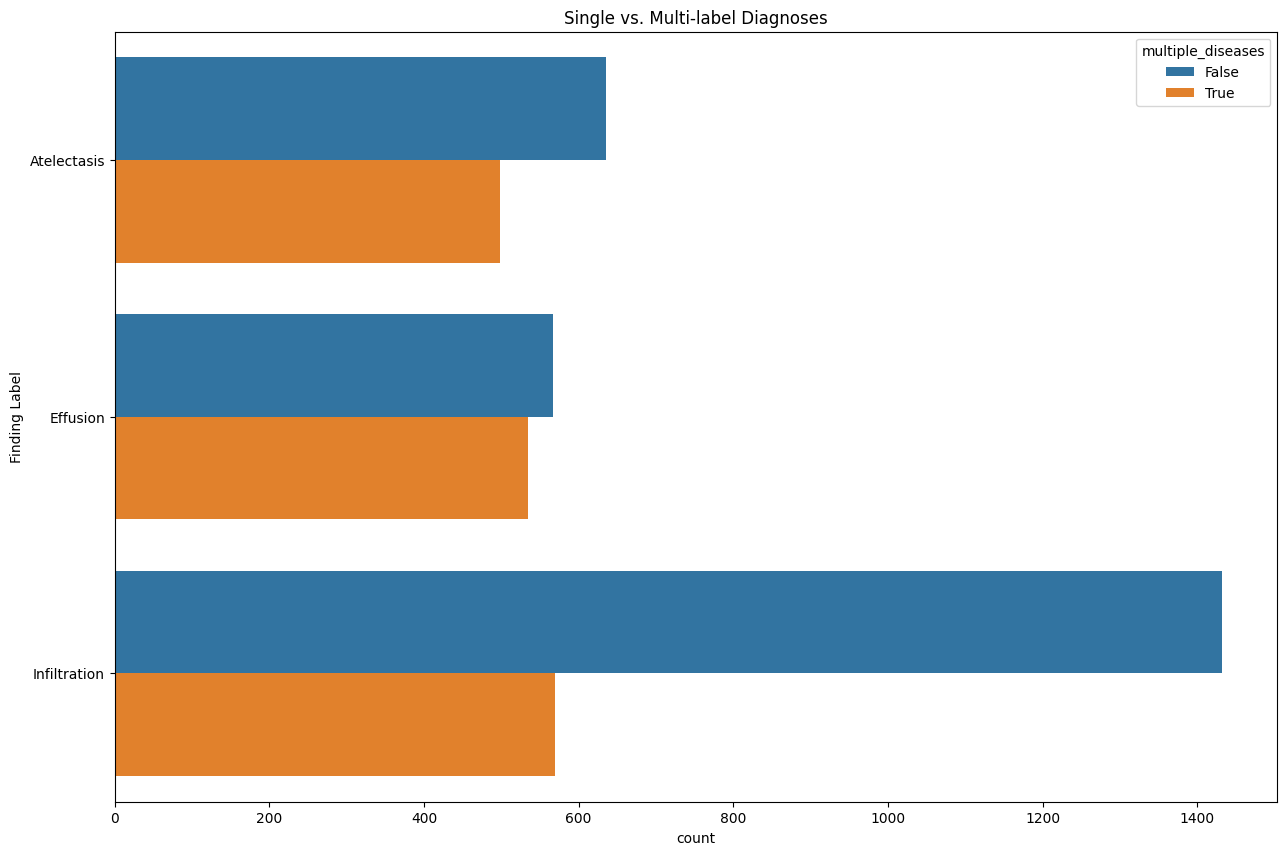

In [27]:
test = df.assign(var1=df['Finding Labels'].str.split('|')).explode('var1')
test["multiple_diseases"] = test[
    'Finding Labels'].str.match(r'\w+\|\w+')  # Identifying multi-label cases
test = test[test["Finding Labels"] != "No Finding"]
test1 = test.groupby(
    ["var1",
        "multiple_diseases"]).size().sort_index().reset_index(name="count")

plt.figure(figsize=(15, 10))
plt.title("Single vs. Multi-label Diagnoses")
ax = sns.barplot(
    y="var1", hue="multiple_diseases", x="count", data=test1, orient='h')
plt.ylabel("Finding Label")
plt.show()

<ipython-input-28-1e07e4688b1d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["tags"] = df_filtered["Finding Labels"].str.split("|")
<ipython-input-28-1e07e4688b1d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["tags"] = df_filtered["tags"].apply(lambda x: sorted(x))


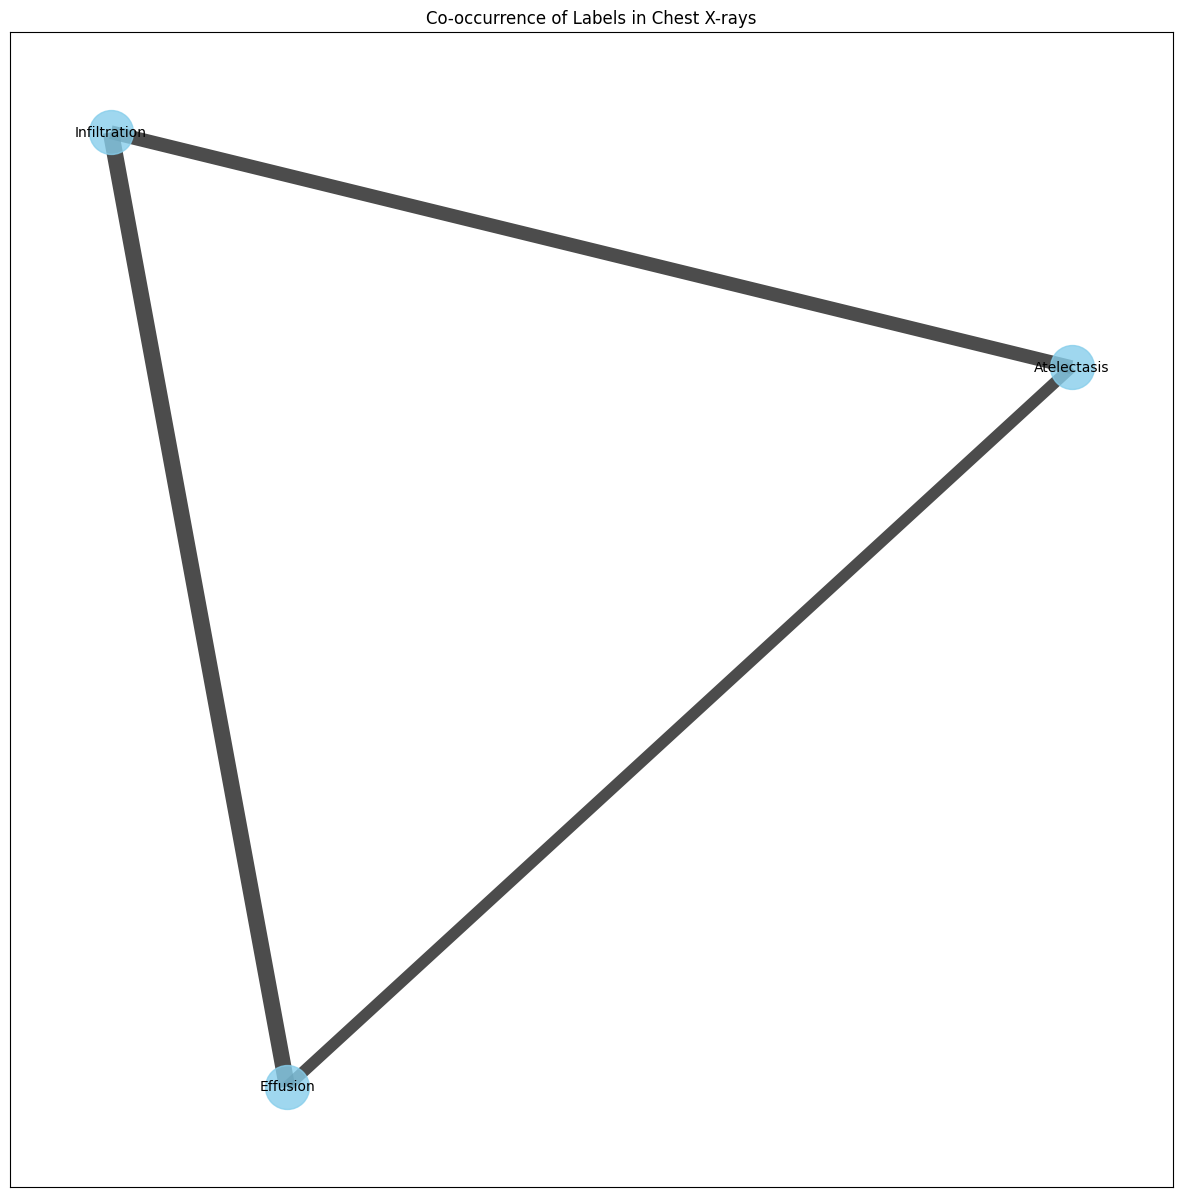

In [28]:
# Preprocessing: Filtering for images with exactly two labels
df_filtered = df[df["Finding Labels"].str.count(r'\|') == 1]
df_filtered["tags"] = df_filtered["Finding Labels"].str.split("|")
df_filtered["tags"] = df_filtered["tags"].apply(lambda x: sorted(x))

# Getting unique labels
all_tags = np.unique(np.concatenate(df_filtered['tags'].values))

# Helper function to add edge weight
def add_edge_weight(head, tail, graph):
    try:
        graph[head][tail]['weight'] += 1
    except:
        graph.add_edge(head, tail, weight=1)

# Initializing the graph
G = nx.Graph()

# Adding nodes (tags)
for t in all_tags:
    G.add_node(t)

# Adding edges (co-occurring tags)
for _, row in df_filtered.iterrows():
    tags = row['tags']
    add_edge_weight(tags[0], tags[1], G)

plt.figure(figsize=(15, 15))
pos = nx.spring_layout(G, k=1.5)  # Adjust k for spacing

# Calculating total edge weights
w_sum = sum([data['weight'] for (_, _, data) in G.edges(data=True)])

# Drawing edges with varying width based on weight
for (node1, node2, data) in G.edges(data=True):
    width = data["weight"] * len(G.nodes) * 10.0 / w_sum
    nx.draw_networkx_edges(
        G, pos, edgelist=[(node1, node2)], width=width, alpha=0.7)

nx.draw_networkx_nodes(
    G, pos, node_size=1000, node_color='skyblue', alpha=0.8)

# Drawing labels without overlap
nx.draw_networkx_labels(G, pos, font_size=10, font_color='black')
plt.title("Co-occurrence of Labels in Chest X-rays")
plt.show()

## Visualizing images with bounding boxes

        Image Index Finding Label     Bbox [x           y          w  \
0  00013118_008.png   Atelectasis  225.084746  547.019217  86.779661   

          h]  Unnamed: 6  Unnamed: 7  Unnamed: 8  
0  79.186441         NaN         NaN         NaN  


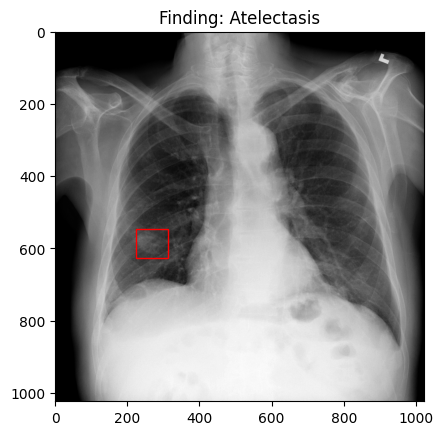

In [29]:
bbox_df = pd.read_csv(drive_path + "BBox_List_2017.csv")

print(bbox_df.head(1))
# Load the first image from dataframe
image_path = drive_path + "images_006/images/" + bbox_df['Image Index'][0]
image = Image.open(image_path)
x = bbox_df['Bbox [x'][0]
y = bbox_df['y'][0]
w = bbox_df['w'][0]
h = bbox_df['h]'][0]

fig, ax = plt.subplots(1)
ax.imshow(image, cmap='gray')

# Create rectangle
rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')

# Add the patch to the img
ax.add_patch(rect)

plt.title(f"Finding: {bbox_df['Finding Label'][0]}")
plt.show()

## Target One Hot Encoding

In [30]:
# create list of targets
df['Finding Labels'] = df['Finding Labels'].apply(lambda x: x.split('|'))

In [31]:
mlb = MultiLabelBinarizer()

ohe_target = mlb.fit_transform(df['Finding Labels'])
ohe_df = pd.DataFrame(ohe_target, columns=mlb.classes_)

target_cols = ohe_df.columns.to_list()

In [32]:
df = pd.concat([df, ohe_df], axis=1)
df.drop(columns='Finding Labels', inplace=True)
# df.columns = df.columns.str.replace(' ', '_')

df.head()

,Image Index,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,Image Path,Atelectasis,Effusion,Infiltration,No Finding
0,00006413_000.png,0,6413,34,M,PA,/content/drive/MyDrive/AAI-590 Capstone/images...,0,0,0,1
1,00018490_000.png,0,18490,32,F,PA,/content/drive/MyDrive/AAI-590 Capstone/images...,0,0,1,0
2,00005699_000.png,0,5699,35,F,PA,/content/drive/MyDrive/AAI-590 Capstone/images...,0,0,0,1
3,00022046_000.png,0,22046,38,M,PA,/content/drive/MyDrive/AAI-590 Capstone/images...,0,0,0,1
4,00007930_000.png,0,7930,51,M,PA,/content/drive/MyDrive/AAI-590 Capstone/images...,1,0,0,0


## Feature Label Encoding

In [33]:
le_gender = LabelEncoder()
le_view_position = LabelEncoder()

df['Patient Gender'] = le_gender.fit_transform(df['Patient Gender'])
df['View Position'] = le_view_position.fit_transform(df['View Position'])

In [34]:
df.head()

,Image Index,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,Image Path,Atelectasis,Effusion,Infiltration,No Finding
0,00006413_000.png,0,6413,34,1,1,/content/drive/MyDrive/AAI-590 Capstone/images...,0,0,0,1
1,00018490_000.png,0,18490,32,0,1,/content/drive/MyDrive/AAI-590 Capstone/images...,0,0,1,0
2,00005699_000.png,0,5699,35,0,1,/content/drive/MyDrive/AAI-590 Capstone/images...,0,0,0,1
3,00022046_000.png,0,22046,38,1,1,/content/drive/MyDrive/AAI-590 Capstone/images...,0,0,0,1
4,00007930_000.png,0,7930,51,1,1,/content/drive/MyDrive/AAI-590 Capstone/images...,1,0,0,0


In [35]:
df.to_csv(drive_path + 'final_dataset.csv')

# Modeling prep

## TTS

In [36]:
df = pd.read_csv(drive_path + 'final_dataset.csv')

In [37]:
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=1997)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=1997)

print(f'Training size: {len(train_df)}')
print(f'Validation size: {len(val_df)}')
print(f'Testing size: {len(test_df)}')

Training size: 9951
Validation size: 1244
Testing size: 1244


## Creating Datasets

In [38]:
IMG_HEIGHT = 224
IMG_WIDTH = 224
CHANNELS = 1

def random_brightness(image):
    return tf.image.random_brightness(image, max_delta=0.1)

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.05),
    tf.keras.layers.experimental.preprocessing.RandomContrast(0.1),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),
    tf.keras.layers.experimental.preprocessing.RandomTranslation(0.05, 0.05),
    tf.keras.layers.Lambda(random_brightness)
])

def load_image(image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image, channels=CHANNELS)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    image = data_augmentation(image)
    return image

def image_label_pairs(dataframe):
    image_paths = dataframe['Image Path'].values
    labels = dataframe.iloc[:, -4:].values
    return image_paths, labels

In [39]:
train_image_paths, train_labels = image_label_pairs(train_df)
val_image_paths, val_labels = image_label_pairs(val_df)
test_image_paths, test_labels = image_label_pairs(test_df)

In [40]:
def create_dataset(image_paths, labels, batch_size, shuffle=True, cache=True):
    path_ds = tf.data.Dataset.from_tensor_slices(image_paths)
    image_ds = path_ds.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

    label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(labels, tf.float32))
    dataset = tf.data.Dataset.zip((image_ds, label_ds))

    if cache:
        dataset = dataset.cache()

    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(image_paths))

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

In [41]:
df.columns

Index(['Unnamed: 0', 'Image Index', 'Follow-up #', 'Patient ID', 'Patient Age',
       'Patient Gender', 'View Position', 'Image Path', 'Atelectasis',
       'Effusion', 'Infiltration', 'No Finding'],
      dtype='object')

In [42]:
batch_size = 40
train_dataset = create_dataset(train_image_paths, train_labels, batch_size)
val_dataset = create_dataset(val_image_paths, val_labels, batch_size, shuffle=False)
test_dataset = create_dataset(test_image_paths, test_labels, batch_size, shuffle=False)

# Initial modeling

In [43]:
# verify GPU availability
if tf.config.list_physical_devices('GPU'):
    print("GPU is available.")
else:
    print("GPU is not available.")

GPU is available.


## No regularization

In [44]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(4, activation='sigmoid')
])

In [45]:
# Compile the model
model.compile(optimizer=Adam(), loss=BinaryCrossentropy(), metrics=['accuracy'])

In [46]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss')

In [47]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    callbacks=[model_checkpoint],
    verbose=1
)

Epoch 1/20
249/249 [==============================] - ETA: 0s - loss: 0.4169 - accuracy: 0.7266

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


249/249 [==============================] - 940s 151ms/step - loss: 0.4169 - accuracy: 0.7266 - val_loss: 0.4013 - val_accuracy: 0.7235
Epoch 2/20
249/249 [==============================] - 5s 20ms/step - loss: 0.3937 - accuracy: 0.7284 - val_loss: 0.3897 - val_accuracy: 0.7227
Epoch 3/20
249/249 [==============================] - 5s 19ms/step - loss: 0.3856 - accuracy: 0.7284 - val_loss: 0.3879 - val_accuracy: 0.7235
Epoch 4/20
249/249 [==============================] - 4s 15ms/step - loss: 0.3815 - accuracy: 0.7286 - val_loss: 0.3935 - val_accuracy: 0.7203
Epoch 5/20
249/249 [==============================] - 4s 15ms/step - loss: 0.3670 - accuracy: 0.7288 - val_loss: 0.3937 - val_accuracy: 0.7146
Epoch 6/20
249/249 [==============================] - 4s 15ms/step - loss: 0.3497 - accuracy: 0.7385 - val_loss: 0.4187 - val_accuracy: 0.7066
Epoch 7/20
249/249 [==============================] - 4s 15ms/step - loss: 0.3190 - accuracy: 0.7532 - val_loss: 0.4521 - val_accuracy: 0.6760
Epoch 8

In [48]:
epochs = range(1, len(history.history['loss']) + 1)
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

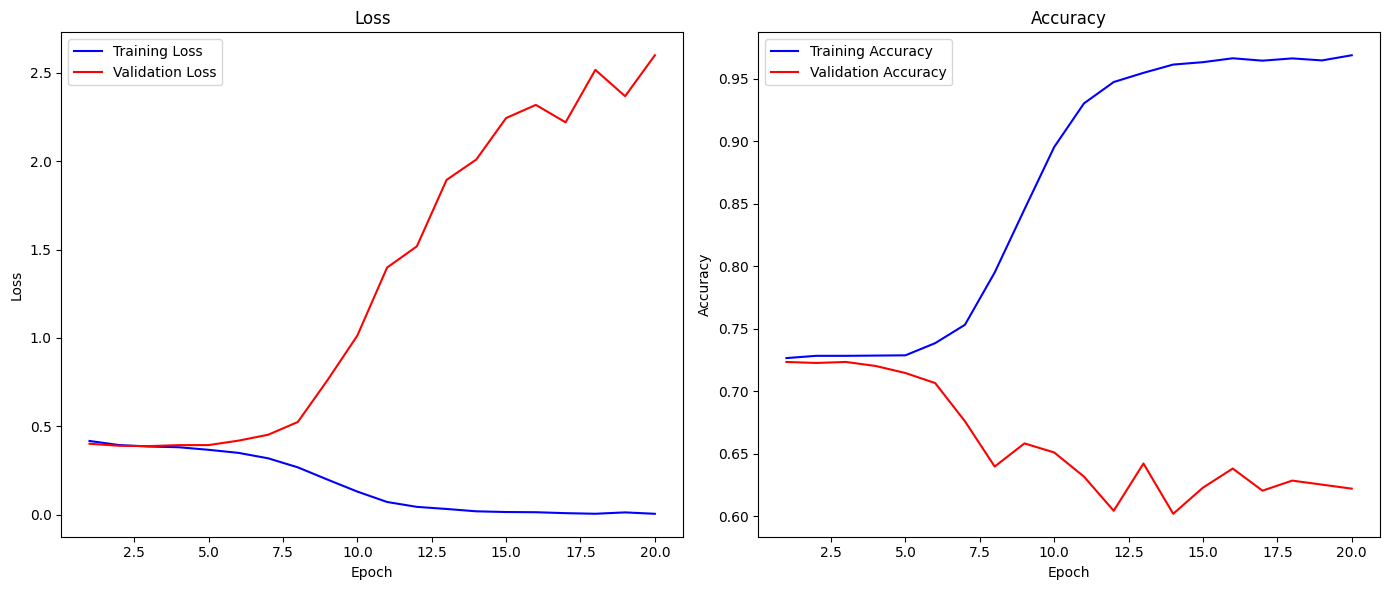

In [49]:
plt.figure(figsize=(14, 6))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, 'b-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r-', label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## Dropout regularization

In [50]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS)),
    MaxPooling2D((2, 2)),
    Dropout(0.25),  # Dropout layer
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),  # Dropout layer
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),  # Dropout layer
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),  # Dropout layer
    Dense(4, activation='sigmoid')
])

In [51]:
# Compile the model
model.compile(optimizer=Adam(), loss=BinaryCrossentropy(), metrics=['accuracy'])

In [52]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    callbacks=[model_checkpoint],
    verbose=1
)

Epoch 1/20
249/249 [==============================] - 10s 23ms/step - loss: 0.4601 - accuracy: 0.7254 - val_loss: 0.4690 - val_accuracy: 0.7235
Epoch 2/20
249/249 [==============================] - 4s 18ms/step - loss: 0.4021 - accuracy: 0.7289 - val_loss: 0.4184 - val_accuracy: 0.7235
Epoch 3/20
249/249 [==============================] - 4s 17ms/step - loss: 0.3938 - accuracy: 0.7287 - val_loss: 0.4094 - val_accuracy: 0.7235
Epoch 4/20
249/249 [==============================] - 4s 17ms/step - loss: 0.3905 - accuracy: 0.7288 - val_loss: 0.4082 - val_accuracy: 0.7235
Epoch 5/20
249/249 [==============================] - 4s 17ms/step - loss: 0.3898 - accuracy: 0.7290 - val_loss: 0.3926 - val_accuracy: 0.7235
Epoch 6/20
249/249 [==============================] - 4s 17ms/step - loss: 0.3880 - accuracy: 0.7289 - val_loss: 0.4154 - val_accuracy: 0.7235
Epoch 7/20
249/249 [==============================] - 4s 17ms/step - loss: 0.3869 - accuracy: 0.7290 - val_loss: 0.4007 - val_accuracy: 0.723

In [53]:
epochs = range(1, len(history.history['loss']) + 1)
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

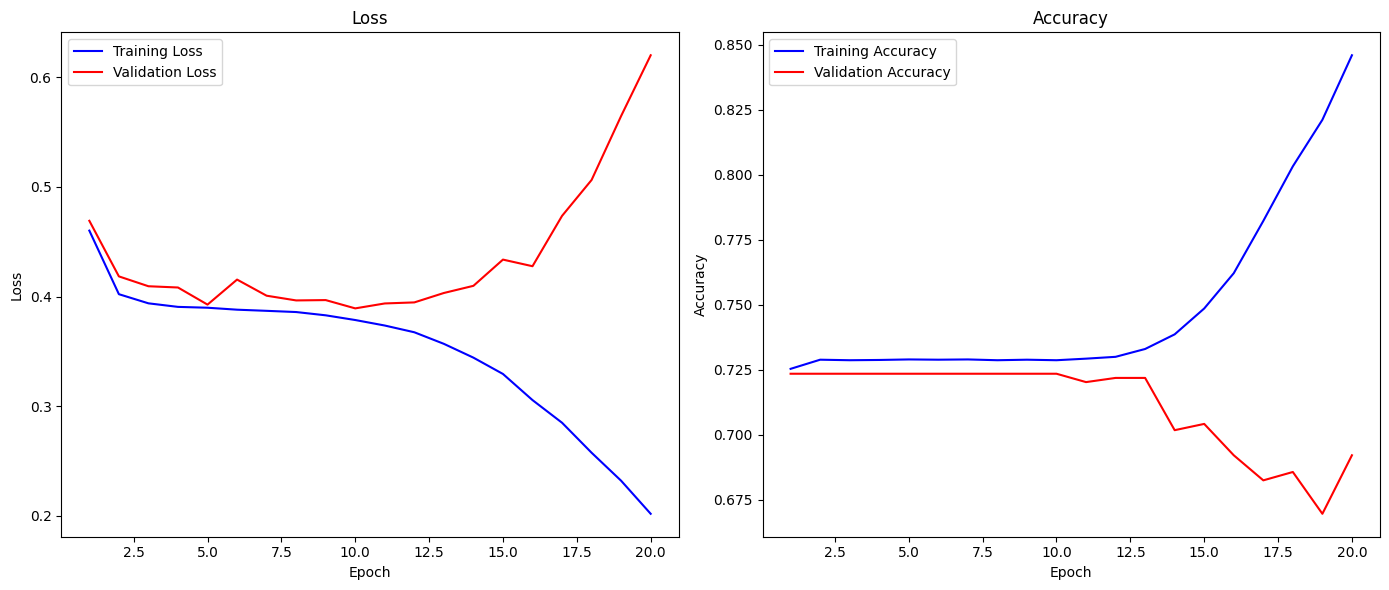

In [54]:
plt.figure(figsize=(14, 6))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, 'b-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r-', label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## L2 Regularization

In [55]:
from tensorflow.keras.regularizers import l2

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu', kernel_regularizer=l2(0.01)),
    Dense(4, activation='sigmoid')
])

In [56]:
# Compile the model
model.compile(optimizer=Adam(), loss=BinaryCrossentropy(), metrics=['accuracy'])

In [57]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    callbacks=[model_checkpoint],
    verbose=1
)

Epoch 1/20
249/249 [==============================] - 6s 16ms/step - loss: 0.8408 - accuracy: 0.7262 - val_loss: 0.4384 - val_accuracy: 0.7235
Epoch 2/20
249/249 [==============================] - 4s 15ms/step - loss: 0.4289 - accuracy: 0.7289 - val_loss: 0.4246 - val_accuracy: 0.7235
Epoch 3/20
249/249 [==============================] - 4s 15ms/step - loss: 0.4197 - accuracy: 0.7289 - val_loss: 0.4102 - val_accuracy: 0.7235
Epoch 4/20
249/249 [==============================] - 4s 15ms/step - loss: 0.4110 - accuracy: 0.7289 - val_loss: 0.4146 - val_accuracy: 0.7235
Epoch 5/20
249/249 [==============================] - 4s 15ms/step - loss: 0.4091 - accuracy: 0.7289 - val_loss: 0.4095 - val_accuracy: 0.7235
Epoch 6/20
249/249 [==============================] - 4s 15ms/step - loss: 0.4062 - accuracy: 0.7289 - val_loss: 0.4061 - val_accuracy: 0.7235
Epoch 7/20
249/249 [==============================] - 4s 15ms/step - loss: 0.4088 - accuracy: 0.7289 - val_loss: 0.4042 - val_accuracy: 0.7235

In [58]:
epochs = range(1, len(history.history['loss']) + 1)
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

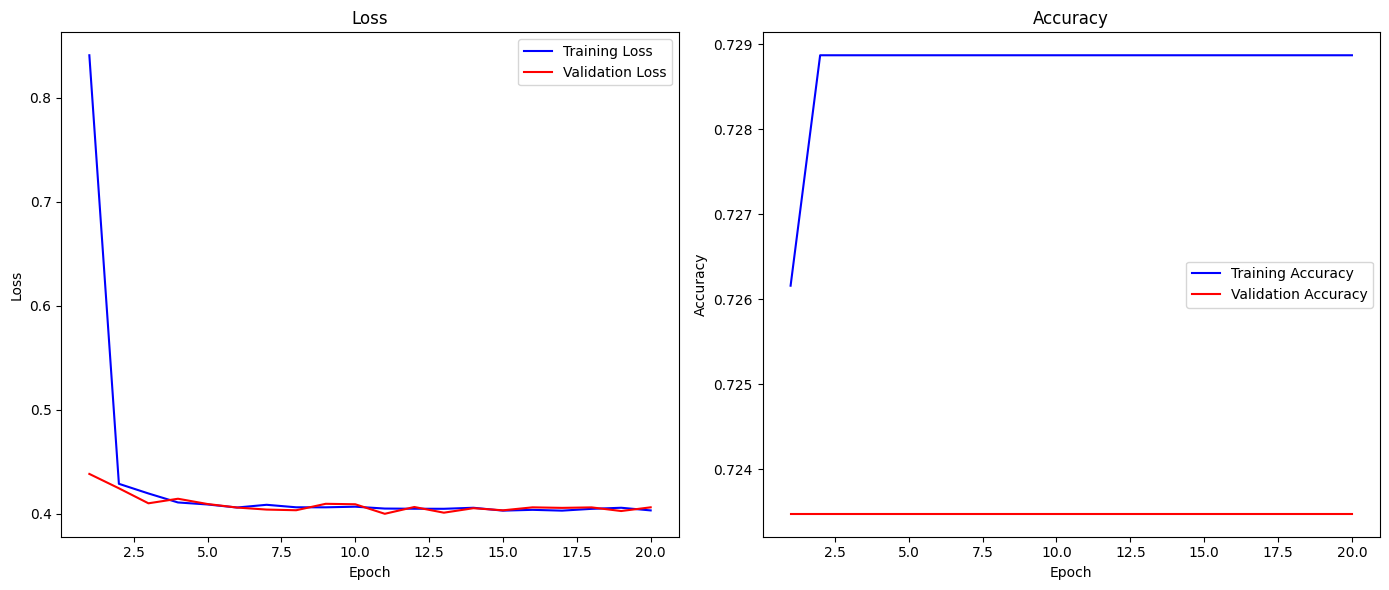

In [59]:
plt.figure(figsize=(14, 6))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, 'b-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r-', label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### Weaker L2 Reg

In [60]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS), kernel_regularizer=l2(0.001)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
    Dense(4, activation='sigmoid')
])

In [61]:
# Compile the model
model.compile(optimizer=Adam(), loss=BinaryCrossentropy(), metrics=['accuracy'])

In [62]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    callbacks=[model_checkpoint],
    verbose=1
)

Epoch 1/20
249/249 [==============================] - 5s 16ms/step - loss: 0.4860 - accuracy: 0.7284 - val_loss: 0.4174 - val_accuracy: 0.7235
Epoch 2/20
249/249 [==============================] - 4s 15ms/step - loss: 0.4192 - accuracy: 0.7289 - val_loss: 0.4085 - val_accuracy: 0.7235
Epoch 3/20
249/249 [==============================] - 4s 15ms/step - loss: 0.4177 - accuracy: 0.7289 - val_loss: 0.4069 - val_accuracy: 0.7235
Epoch 4/20
249/249 [==============================] - 4s 15ms/step - loss: 0.4073 - accuracy: 0.7289 - val_loss: 0.4098 - val_accuracy: 0.7235
Epoch 5/20
249/249 [==============================] - 4s 15ms/step - loss: 0.4025 - accuracy: 0.7289 - val_loss: 0.4005 - val_accuracy: 0.7235
Epoch 6/20
249/249 [==============================] - 4s 15ms/step - loss: 0.4018 - accuracy: 0.7289 - val_loss: 0.4045 - val_accuracy: 0.7235
Epoch 7/20
249/249 [==============================] - 4s 15ms/step - loss: 0.4001 - accuracy: 0.7289 - val_loss: 0.3976 - val_accuracy: 0.7235

In [63]:
epochs = range(1, len(history.history['loss']) + 1)
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

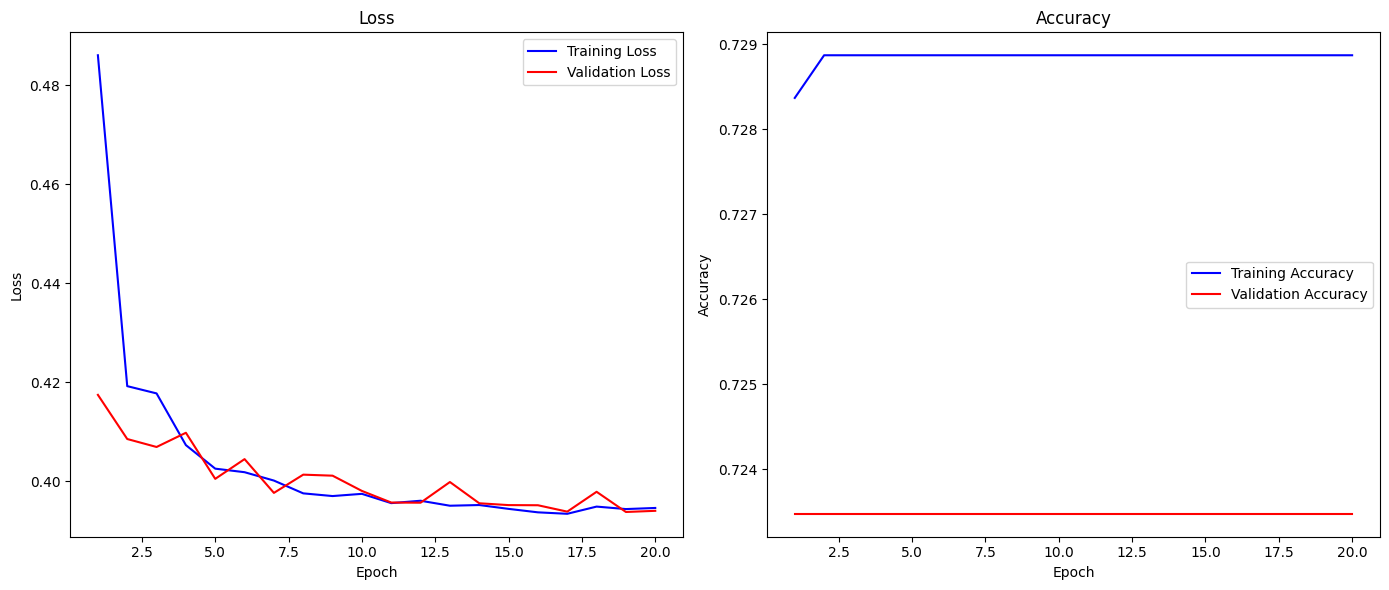

In [64]:
plt.figure(figsize=(14, 6))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, 'b-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r-', label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Increasing model complexity

In [65]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu'),  # Additional layer
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),  # Additional dense layer
    Dense(4, activation='sigmoid')
])

In [66]:
# Compile the model
model.compile(optimizer=Adam(), loss=BinaryCrossentropy(), metrics=['accuracy'])

In [67]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    callbacks=[model_checkpoint],
    verbose=1
)

Epoch 1/20
249/249 [==============================] - 6s 16ms/step - loss: 0.4132 - accuracy: 0.7270 - val_loss: 0.3934 - val_accuracy: 0.7235
Epoch 2/20
249/249 [==============================] - 4s 14ms/step - loss: 0.3939 - accuracy: 0.7289 - val_loss: 0.4194 - val_accuracy: 0.7235
Epoch 3/20
249/249 [==============================] - 4s 14ms/step - loss: 0.3878 - accuracy: 0.7289 - val_loss: 0.3958 - val_accuracy: 0.7235
Epoch 4/20
249/249 [==============================] - 4s 14ms/step - loss: 0.3902 - accuracy: 0.7290 - val_loss: 0.3923 - val_accuracy: 0.7235
Epoch 5/20
249/249 [==============================] - 4s 14ms/step - loss: 0.3839 - accuracy: 0.7289 - val_loss: 0.3912 - val_accuracy: 0.7235
Epoch 6/20
249/249 [==============================] - 4s 14ms/step - loss: 0.3820 - accuracy: 0.7289 - val_loss: 0.3898 - val_accuracy: 0.7235
Epoch 7/20
249/249 [==============================] - 4s 17ms/step - loss: 0.3797 - accuracy: 0.7288 - val_loss: 0.3877 - val_accuracy: 0.7235

In [68]:
epochs = range(1, len(history.history['loss']) + 1)
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

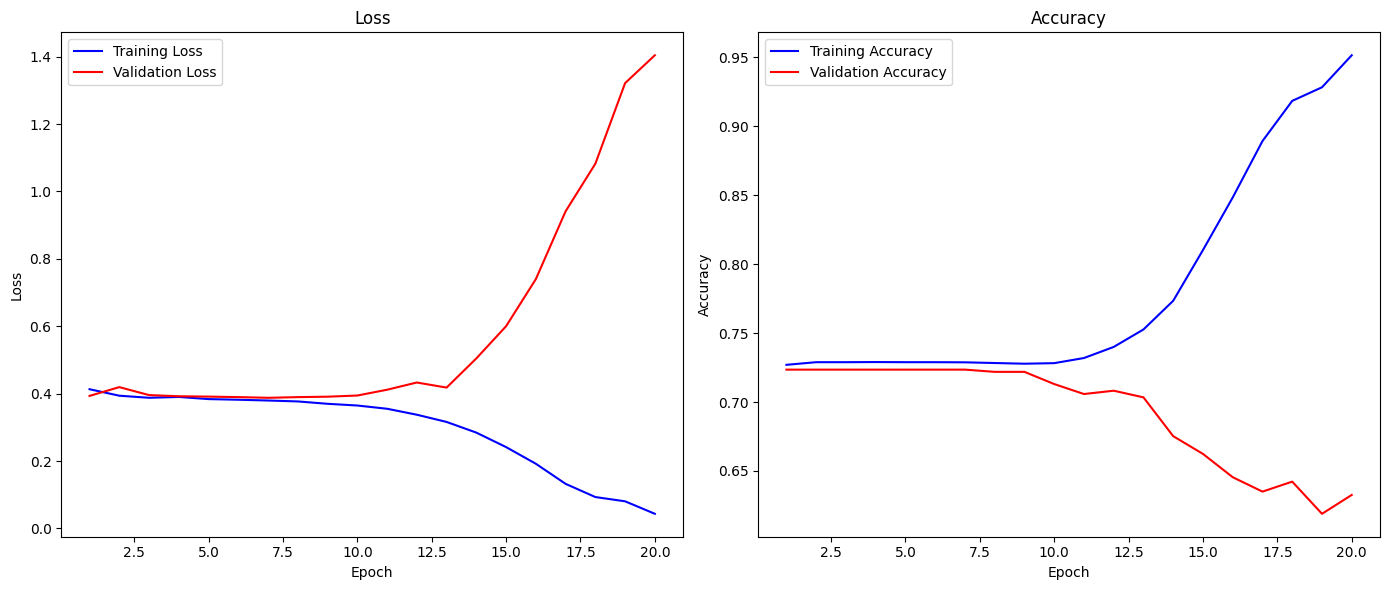

In [69]:
plt.figure(figsize=(14, 6))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, 'b-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r-', label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## Adding dropout

In [70]:
# Define the model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS)),
    Conv2D(32, (3, 3), activation='relu'),  # Additional convolutional layer
    MaxPooling2D((2, 2)),
    Dropout(.25),

    Conv2D(64, (3, 3), activation='relu'),
    Conv2D(64, (3, 3), activation='relu'),  # Additional convolutional layer
    MaxPooling2D((2, 2)),
    Dropout(.25),

    Conv2D(128, (3, 3), activation='relu'),
    Conv2D(128, (3, 3), activation='relu'),  # Additional convolutional layer
    MaxPooling2D((2, 2)),
    Dropout(.25),

    Conv2D(256, (3, 3), activation='relu'),
    Conv2D(256, (3, 3), activation='relu'),  # Additional convolutional layer
    MaxPooling2D((2, 2)),
    Dropout(.25),

    Flatten(),
    Dense(512, activation='relu'),
    Dense(512, activation='relu'),  # Additional dense layer
    Dropout(.5),

    Dense(256, activation='relu'),
    Dropout(.5),

    Dense(4, activation='sigmoid')
])

In [71]:
# Compile the model
model.compile(optimizer=Adam(), loss=BinaryCrossentropy(), metrics=['accuracy'])

In [72]:
# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    callbacks=[model_checkpoint],
    verbose=1
)

Epoch 1/20
249/249 [==============================] - 26s 56ms/step - loss: 0.4315 - accuracy: 0.7249 - val_loss: 0.4074 - val_accuracy: 0.7235
Epoch 2/20
249/249 [==============================] - 7s 30ms/step - loss: 0.4166 - accuracy: 0.7289 - val_loss: 0.4071 - val_accuracy: 0.7235
Epoch 3/20
249/249 [==============================] - 7s 30ms/step - loss: 0.4139 - accuracy: 0.7289 - val_loss: 0.4089 - val_accuracy: 0.7235
Epoch 4/20
249/249 [==============================] - 8s 30ms/step - loss: 0.4116 - accuracy: 0.7289 - val_loss: 0.4074 - val_accuracy: 0.7235
Epoch 5/20
249/249 [==============================] - 7s 30ms/step - loss: 0.4110 - accuracy: 0.7289 - val_loss: 0.4075 - val_accuracy: 0.7235
Epoch 6/20
249/249 [==============================] - 7s 30ms/step - loss: 0.4118 - accuracy: 0.7289 - val_loss: 0.4079 - val_accuracy: 0.7235
Epoch 7/20
249/249 [==============================] - 7s 30ms/step - loss: 0.4114 - accuracy: 0.7289 - val_loss: 0.4073 - val_accuracy: 0.723

In [73]:
epochs = range(1, len(history.history['loss']) + 1)
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

In [74]:
from tensorflow.keras.models import save_model
model.save('best_model_complete.h5')

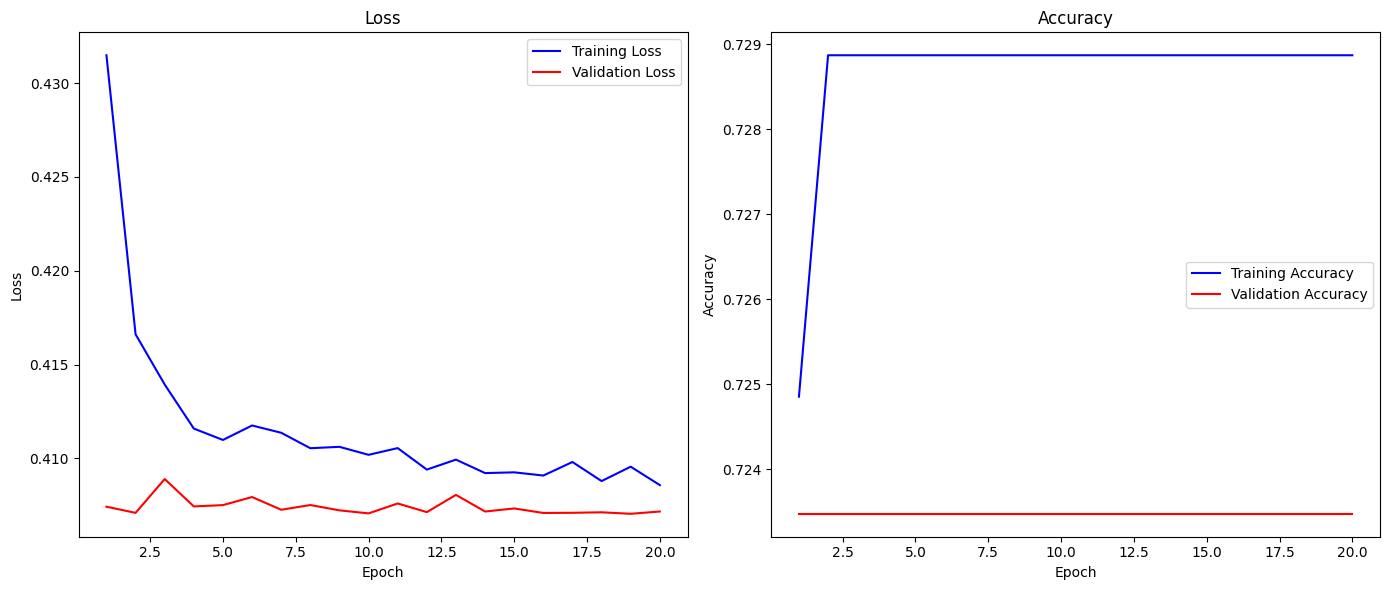

In [75]:
plt.figure(figsize=(14, 6))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, 'b-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r-', label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [78]:
# Load the entire model
model = tf.keras.models.load_model('best_model_complete.h5')

# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Predict on the test dataset
y_pred = model.predict(test_dataset)
y_true = np.concatenate([y for x, y in test_dataset], axis=0)

# Binarize predictions
y_pred_binary = (y_pred > 0.5).astype(int)

# Generate classification report
from sklearn.metrics import classification_report, roc_auc_score

print(classification_report(y_true, y_pred_binary, target_names=['No Finding', 'Infiltration', 'Effusion', 'Atelectasis']))

# Calculate AUC-ROC for each class
auc_roc = roc_auc_score(y_true, y_pred, average=None)
for i, label in enumerate(['No Finding', 'Infiltration', 'Effusion', 'Atelectasis']):
    print(f"{label}: AUC-ROC = {auc_roc[i]:.4f}")

# Calculate macro and micro average AUC-ROC
macro_auc_roc = roc_auc_score(y_true, y_pred, average='macro')
micro_auc_roc = roc_auc_score(y_true, y_pred, average='micro')
print(f"Macro AUC-ROC: {macro_auc_roc:.4f}")
print(f"Micro AUC-ROC: {micro_auc_roc:.4f}")

32/32 [==============================] - 1s 11ms/step - loss: 0.4113 - accuracy: 0.7291
Test Loss: 0.4113492965698242
Test Accuracy: 0.729099690914154
32/32 [==============================] - 0s 9ms/step
              precision    recall  f1-score   support

  No Finding       0.00      0.00      0.00       112
Infiltration       0.00      0.00      0.00       110
    Effusion       0.00      0.00      0.00       214
 Atelectasis       0.73      1.00      0.84       907

   micro avg       0.73      0.68      0.70      1343
   macro avg       0.18      0.25      0.21      1343
weighted avg       0.49      0.68      0.57      1343
 samples avg       0.73      0.73      0.73      1343

No Finding: AUC-ROC = 0.5031
Infiltration: AUC-ROC = 0.5032
Effusion: AUC-ROC = 0.5019
Atelectasis: AUC-ROC = 0.5000
Macro AUC-ROC: 0.5021
Micro AUC-ROC: 0.8181


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Keras Tuner**

In [79]:
IMG_HEIGHT = 224
IMG_WIDTH = 224
CHANNELS = 1

# Define the model building function
def build_model(hp):
    model = Sequential()
    model.add(Conv2D(hp.Int('conv1_units', min_value=32, max_value=128, step=32),
                     (3, 3),
                     activation=hp.Choice('activation', values=['relu', 'leaky_relu']),
                     input_shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(hp.Float('dropout1', 0.2, 0.5, step=0.1)))

    for i in range(hp.Int('num_conv_layers', 1, 4)):
        model.add(Conv2D(hp.Int(f'conv{i+2}_units', min_value=32, max_value=128, step=32),
                         (3, 3),
                         activation=hp.Choice('activation', values=['relu', 'leaky_relu'])))
        model.add(BatchNormalization())
        model.add(MaxPooling2D((2, 2)))
        model.add(Dropout(hp.Float(f'dropout_conv{i+2}', 0.2, 0.5, step=0.1)))

    model.add(Flatten())

    for i in range(hp.Int('num_dense_layers', 1, 3)):
        model.add(Dense(hp.Int(f'dense{i+1}_units', min_value=128, max_value=512, step=128),
                        activation=hp.Choice('activation', values=['relu', 'leaky_relu'])))
        model.add(Dropout(hp.Float(f'dropout_dense{i+1}', 0.2, 0.5, step=0.1)))

    model.add(Dense(4, activation='sigmoid'))

    model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5])),
                  loss=BinaryCrossentropy(),
                  metrics=['accuracy'])

    return model

# Instantiate the tuner
tuner = kt.Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=50,
    factor=3,
    directory='my_dir',
    project_name='chest_xray_classification',
    distribution_strategy=tf.distribute.MirroredStrategy()  # Parallelize the search
)

# Display a summary of the search space
tuner.search_space_summary()

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss')

# Perform the hyperparameter search
tuner.search(train_dataset, validation_data=val_dataset, epochs=50, callbacks=[early_stopping, model_checkpoint])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
The hyperparameter search is complete. The optimal number of units in the first convolutional layer is {best_hps.get('conv1_units')},
the optimal number of convolutional layers is {best_hps.get('num_conv_layers')},
the optimal number of units in the dense layers is {best_hps.get('dense1_units')},
and the optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.
""")


Trial 84 Complete [00h 02m 08s]
val_loss: 0.40926113724708557

Best val_loss So Far: 0.3842177391052246
Total elapsed time: 01h 41m 04s

The hyperparameter search is complete. The optimal number of units in the first convolutional layer is 32,
the optimal number of convolutional layers is 4,
the optimal number of units in the dense layers is 512,
and the optimal learning rate for the optimizer is 0.001.



In [80]:
# Build the model with the optimal hyperparameters
model = tuner.hypermodel.build(best_hps)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=15,
    callbacks=[early_stopping, model_checkpoint]
)

# Load the best model
model.load_weights('best_model.h5')

# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Predict on the test dataset
y_pred = model.predict(test_dataset)
y_true = np.concatenate([y for x, y in test_dataset], axis=0)

y_pred_binary = (y_pred > 0.5).astype(int)

# Generate classification report
print(classification_report(y_true, y_pred_binary, target_names=target_cols))

# Calculate AUC-ROC for each class
auc_roc = roc_auc_score(y_true, y_pred, average=None)
for i, label in enumerate(target_cols):
    print(f"{label}: AUC-ROC = {auc_roc[i]:.4f}")

# Calculate macro and micro average AUC-ROC
macro_auc_roc = roc_auc_score(y_true, y_pred, average='macro')
micro_auc_roc = roc_auc_score(y_true, y_pred, average='micro')
print(f"Macro AUC-ROC: {macro_auc_roc:.4f}")
print(f"Micro AUC-ROC: {micro_auc_roc:.4f}")

Epoch 1/15
249/249 [==============================] - 12s 34ms/step - loss: 0.4435 - accuracy: 0.7194 - val_loss: 0.4320 - val_accuracy: 0.7235
Epoch 2/15
249/249 [==============================] - 8s 33ms/step - loss: 0.4094 - accuracy: 0.7290 - val_loss: 0.4014 - val_accuracy: 0.7235
Epoch 3/15
249/249 [==============================] - 8s 33ms/step - loss: 0.4002 - accuracy: 0.7282 - val_loss: 0.4065 - val_accuracy: 0.7235
Epoch 4/15
249/249 [==============================] - 8s 33ms/step - loss: 0.3951 - accuracy: 0.7276 - val_loss: 0.3938 - val_accuracy: 0.7235
Epoch 5/15
249/249 [==============================] - 8s 33ms/step - loss: 0.3933 - accuracy: 0.7274 - val_loss: 0.4017 - val_accuracy: 0.7227
Epoch 6/15
249/249 [==============================] - 8s 33ms/step - loss: 0.3900 - accuracy: 0.7271 - val_loss: 0.3913 - val_accuracy: 0.7211
Epoch 7/15
249/249 [==============================] - 8s 33ms/step - loss: 0.3881 - accuracy: 0.7283 - val_loss: 0.4511 - val_accuracy: 0.719

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
